In [1]:
from paretoKnapsackInfluence import *

import shutil
import matplotlib as mpl
from pathlib import Path

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}"
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Dataset paths
base_dir = Path.cwd().resolve().parents[1]
nethept_path = base_dir / "datasets" / "raw_data" / "influence" / "NetHEPT" / "hep.txt"
netphy_path = base_dir / "datasets" / "raw_data" / "influence" / "NetPHY" / "phy.txt"

### Single-Run Plotting (Influence Maximization)

In [2]:
def findSingleRunSolutionsKnapsackInfluence(G, node_costs, maxBudget, num_samples=35, num_runs=6, dataset_name=""):
    '''
    Run algorithms for a fixed number of runs and plot each run in a subplot (no interpolation).
    Each run corresponds to an independent IM instance with its own Monte Carlo samples.
    '''
    # Cost grid (same for all budgets within this run)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    algo_names = ["ParetoGreedy", "C-Greedy", "F-Greedy", "TopK"]

    def sort_pairs(costs, infls):
        if len(costs) == 0:
            return np.array([]), np.array([])
        pairs = sorted(zip(costs, infls), key=lambda x: x[0])
        return np.array([p[0] for p in pairs], dtype=float), np.array([p[1] for p in pairs], dtype=float)

    def pareto_prune_by_cost(costs, infls):
        if len(costs) == 0:
            return np.array([]), np.array([])
        best_by_cost = {}
        for c, v in zip(costs, infls):
            if c not in best_by_cost or v > best_by_cost[c]:
                best_by_cost[c] = v
        pruned_costs = np.array(sorted(best_by_cost.keys()), dtype=float)
        pruned_infls = np.array([best_by_cost[c] for c in pruned_costs], dtype=float)
        return pruned_costs, pruned_infls

    def format_points(costs, infls):
        return [f"({c:.2f}, {v:.3f})" for c, v in zip(costs, infls)]

    # Plot settings (match influence notebook styling)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "F-Greedy": tab10_colors[2],
        "ParetoGreedy": tab10_colors[3],
    }
    marker_map = {
        "TopK": "o",
        "F-Greedy": "s",
        "C-Greedy": "^",
        "ParetoGreedy": "X",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "F-Greedy": (0, (2, 2)),
        "C-Greedy": (0, (3, 2)),
        "ParetoGreedy": (0, (4, 2)),
    }

    # Prepare figure (2 rows x 3 columns)
    n_runs = int(num_runs)
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = np.array(axes).reshape(-1)

    # Per-dataset runtime summary
    runtime_totals = {alg: 0.0 for alg in algo_names}

    for ax_idx in range(n_runs):
        ax = axes[ax_idx]

        # Generate graph samples once to share across algorithms (per run)
        graph_samples = []
        for _ in range(num_samples):
            G_sample = nx.Graph()
            neighbors = defaultdict(set)
            connected_components = defaultdict()
            for u, v, data in G.edges(data=True):
                success = np.random.uniform(0, 1)
                if success < data.get('weight', 0.1):
                    G_sample.add_edge(u, v)
                    neighbors[u].add(v)
                    neighbors[v].add(u)
            for c in nx.connected_components(G_sample):
                for node in c:
                    connected_components[node] = c
            graph_samples.append((G_sample, neighbors, connected_components))

        # Prefix Pareto + Coverage Linear (computed once at full budget)
        pareto_full = paretoKnapsackInfluence(
            G=G,
            node_costs=node_costs,
            budget=maxBudget,
            num_samples=num_samples,
            graph_samples=graph_samples
        )
        pp1_costs, pp1_influences, pp1_map, pp1_time = pareto_full.prefixParetoGreedy_1Guess()
        cl_costs, cl_influences, cl_map, cl_time = pareto_full.F_Greedy()
        cl_costs, cl_influences = pareto_prune_by_cost(cl_costs, cl_influences)

        # Per-budget results
        influences = {alg: [] for alg in algo_names}
        runtimes = {alg: [] for alg in algo_names}

        for budgetVal in cost_arr:
            pareto = paretoKnapsackInfluence(
                G=G,
                node_costs=node_costs,
                budget=budgetVal,
                num_samples=num_samples,
                graph_samples=graph_samples
            )

            # C-Greedy (replacement for C-Greedy-1)
            _, og_infl, og_cost, og_time = pareto.oneGuessGreedyPlus()
            influences['C-Greedy'].append(og_infl)
            runtimes['C-Greedy'].append(og_time)

            # Top-k (add nodes until budget is hit)
            _, tk_infl, tk_cost, tk_time = pareto.top_k()
            influences['TopK'].append(tk_infl)
            runtimes['TopK'].append(tk_time)

        runtimes['ParetoGreedy'].append(pp1_time)
        runtimes['F-Greedy'].append(cl_time)

        # Log pareto points per algorithm
        pg_costs, pg_infls = sort_pairs(pp1_costs, pp1_influences)
        cl_costs_sorted, cl_infls_sorted = sort_pairs(cl_costs, cl_influences)
        logging.info("Run %d pareto points - ParetoGreedy: %s", ax_idx, format_points(pg_costs, pg_infls))
        logging.info("Run %d pareto points - F-Greedy: %s", ax_idx, format_points(cl_costs_sorted, cl_infls_sorted))
        logging.info("Run %d pareto points - C-Greedy: %s", ax_idx, format_points(cost_arr, influences['C-Greedy']))
        logging.info("Run %d pareto points - TopK: %s", ax_idx, format_points(cost_arr, influences['TopK']))

        series_map = {
            "ParetoGreedy": sort_pairs(pp1_costs, pp1_influences),
            "F-Greedy": sort_pairs(cl_costs, cl_influences),
            "C-Greedy": (cost_arr, np.array(influences['C-Greedy'], dtype=float)),
            "TopK": (cost_arr, np.array(influences['TopK'], dtype=float))
        }

        for i, alg in enumerate(algo_names):
            color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
            marker = marker_map.get(alg, 'o')
            x_vals, y_vals = series_map[alg]
            ax.plot(
                x_vals, y_vals,
                label="_nolegend_",
                color=color,
                linestyle=linestyle_map.get(alg, (0, (1, 1))),
                marker=marker,
                markersize=7 if alg == "ParetoGreedy" else 6,
                markeredgewidth=0,
                markeredgecolor='none',
                linewidth=1.8,
                alpha=0.9,
                zorder=4 if alg == "ParetoGreedy" else 3
            )

        ax.set_title("")
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', labelsize=24)

        # Runtime summary for this run
        for alg in algo_names:
            total_runtime = float(np.nansum(np.array(runtimes.get(alg, []), dtype=float)))
            runtime_totals[alg] += total_runtime

    # Hide unused subplots if any
    for ax in axes[n_runs:]:
        ax.axis('off')

    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            if idx >= len(axes):
                continue
            ax = axes[idx]
            if r == n_rows - 1:
                ax.set_xlabel(r'Seed cost, $c_\ell$', fontsize=24)
            if c == 0:
                ax.set_ylabel(r'Expected influence, $f$', fontsize=24)

    fig.tight_layout(rect=[0.03, 0.03, 1, 0.9])

    # Save figure
    plots_dir = base_dir / "plots" / "knapsack" / "single"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack_single_run.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (seconds)
    runtime_lines = ["Runtime summary (seconds):"]
    for alg in algo_names:
        runtime_lines.append(f"  - {alg}: {runtime_totals[alg]:.3f}")
    logging.info("\n".join(runtime_lines))

## NetHEPT

2026-02-06 18:43:13,735 |INFO: Imported influence graph with 354 nodes and 840 edges
2026-02-06 18:43:13,831 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:354, Budget=75
2026-02-06 18:47:09,108 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:354, Budget=1.0
2026-02-06 18:47:09,113 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:354, Budget=6.285714285714286
2026-02-06 18:47:09,244 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:354, Budget=11.571428571428571
2026-02-06 18:47:09,578 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:354, Budget=16.857142857142858
2026-02-06 18:47:10,036 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:354, Budget=22.142857142857142
2026-02-06 18:47:10,568 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:354, Budget=27.428571428571427
2026-02-06 18:47:11,153 |INFO: Initialized Pareto Influenc

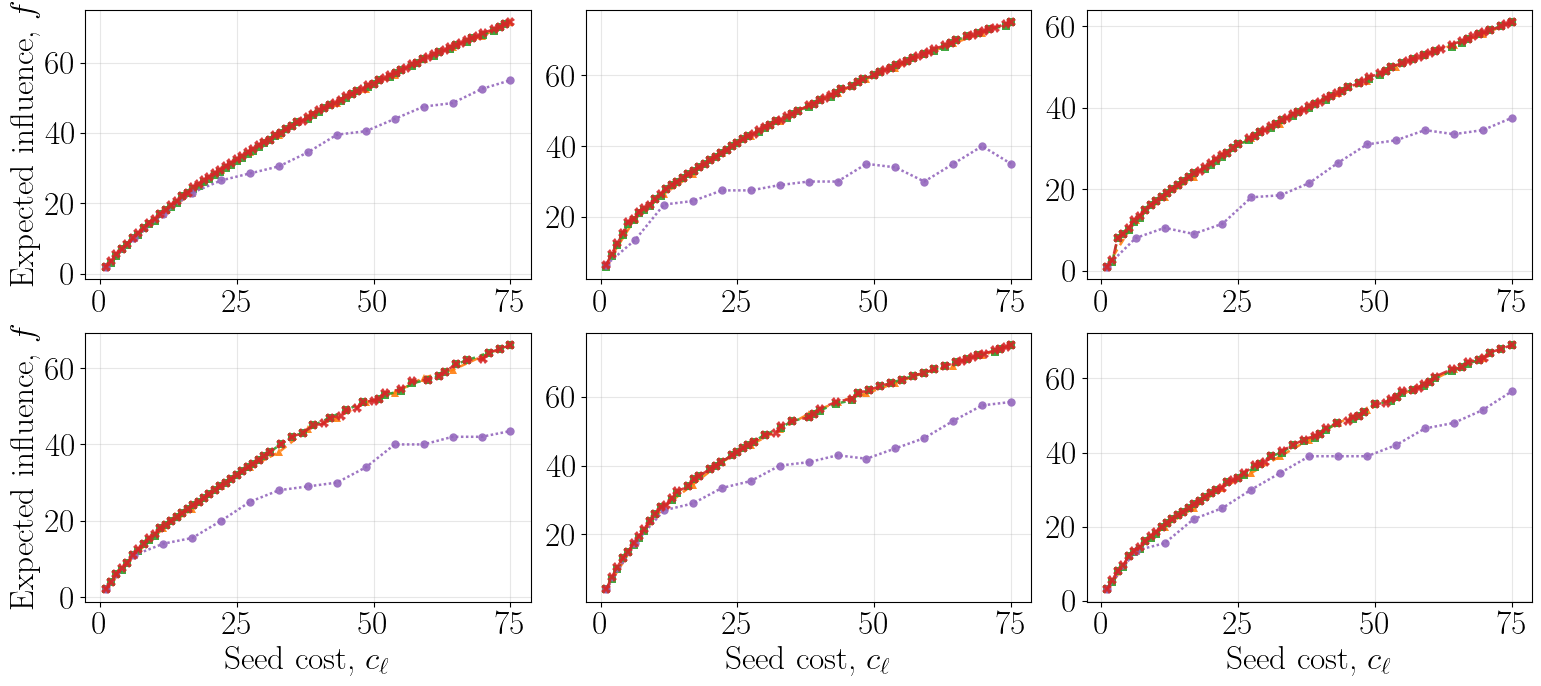

2026-02-06 19:07:12,931 |INFO: Runtime summary (seconds):
  - ParetoGreedy: 16.405
  - C-Greedy: 140.540
  - F-Greedy: 1280.272
  - TopK: 0.417


In [3]:
# Load NetHEPT graph and node costs
G_HEPT, node_costs_HEPT = import_influence_data(nethept_path)

# Run for NetHEPT
findSingleRunSolutionsKnapsackInfluence(
    G_HEPT,
    node_costs_HEPT,
    maxBudget=75,
    num_samples=2,
    num_runs=6,
    dataset_name="NetHEPT"
 )

## NetPHY

2026-02-06 19:07:14,519 |INFO: Imported influence graph with 151 nodes and 735 edges
2026-02-06 19:07:14,565 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=50
2026-02-06 19:07:26,272 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=1.0
2026-02-06 19:07:26,273 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=4.5
2026-02-06 19:07:26,286 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=8.0
2026-02-06 19:07:26,338 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=11.5
2026-02-06 19:07:26,474 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=15.0
2026-02-06 19:07:26,677 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=18.5
2026-02-06 19:07:26,861 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=22.0
2026-02-06 19:07

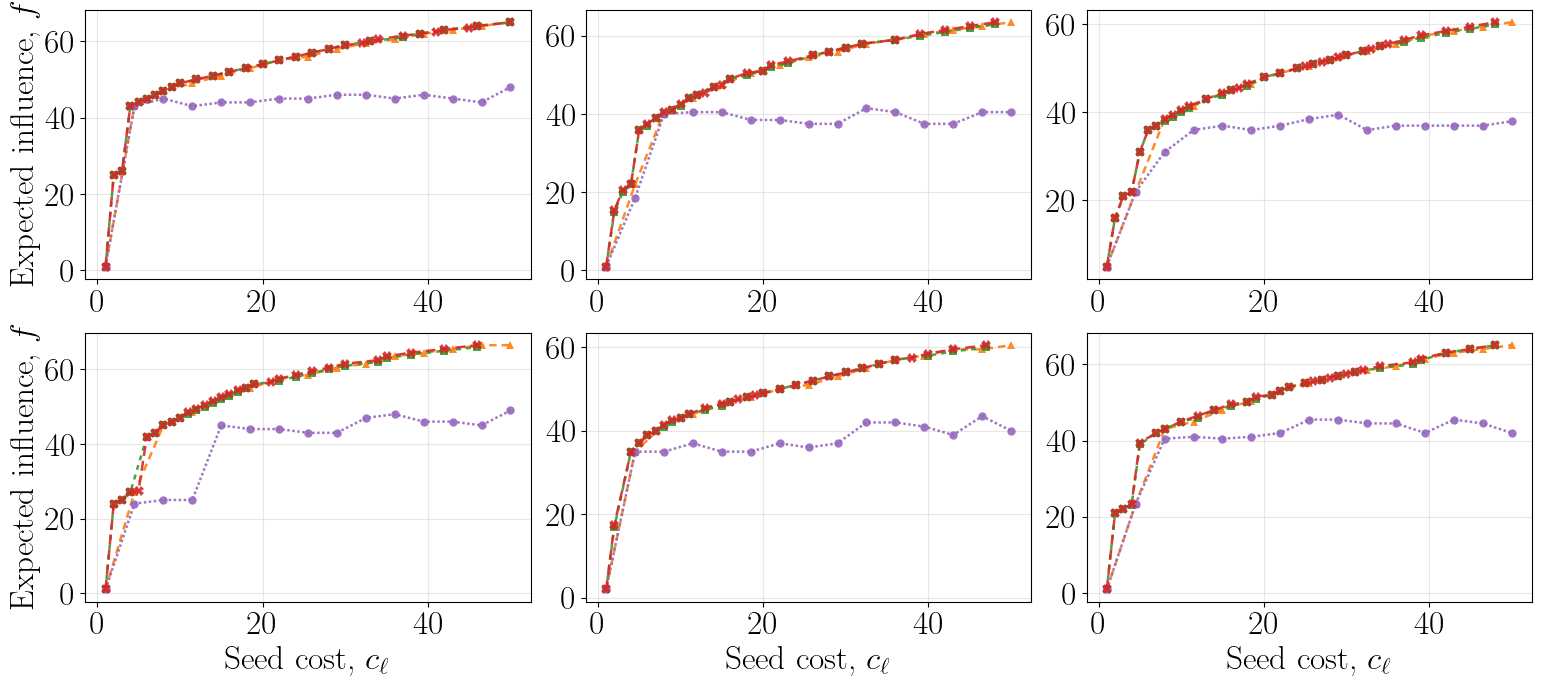

2026-02-06 19:08:56,868 |INFO: Runtime summary (seconds):
  - ParetoGreedy: 3.076
  - C-Greedy: 23.469
  - F-Greedy: 74.675
  - TopK: 0.158


In [4]:
# Load NetPHY graph and node costs
G_PHY, node_costs_PHY = import_influence_data(netphy_path)

# Run for NetPHY
findSingleRunSolutionsKnapsackInfluence(
    G_PHY,
    node_costs_PHY,
    maxBudget=50,
    num_samples=2,
    num_runs=6,
    dataset_name="NetPHY"
 )